In [18]:
import pandas as pd
import seaborn as sns

In [27]:
df = pd.read_csv("comparison.csv")

In [50]:
r2_cols = ["dataset"] + [x for x in df.columns if x.find("r2") > 0]
rms_cols = ["dataset"] + [x for x in df.columns if x.find("rms") > 0]

In [52]:
r2_df = df[r2_cols].melt(id_vars="dataset")
rms_df = df[rms_cols].melt(id_vars="dataset")

In [53]:
r2_df.columns = ['Dataset',"algorithm","R2"]
rms_df.columns = ['Dataset',"algorithm","RMSE"]

In [54]:
r2_df['Method'] = [x.split("_")[0].upper() for x in r2_df.algorithm]
rms_df['Method'] = [x.split("_")[0].upper() for x in rms_df.algorithm]

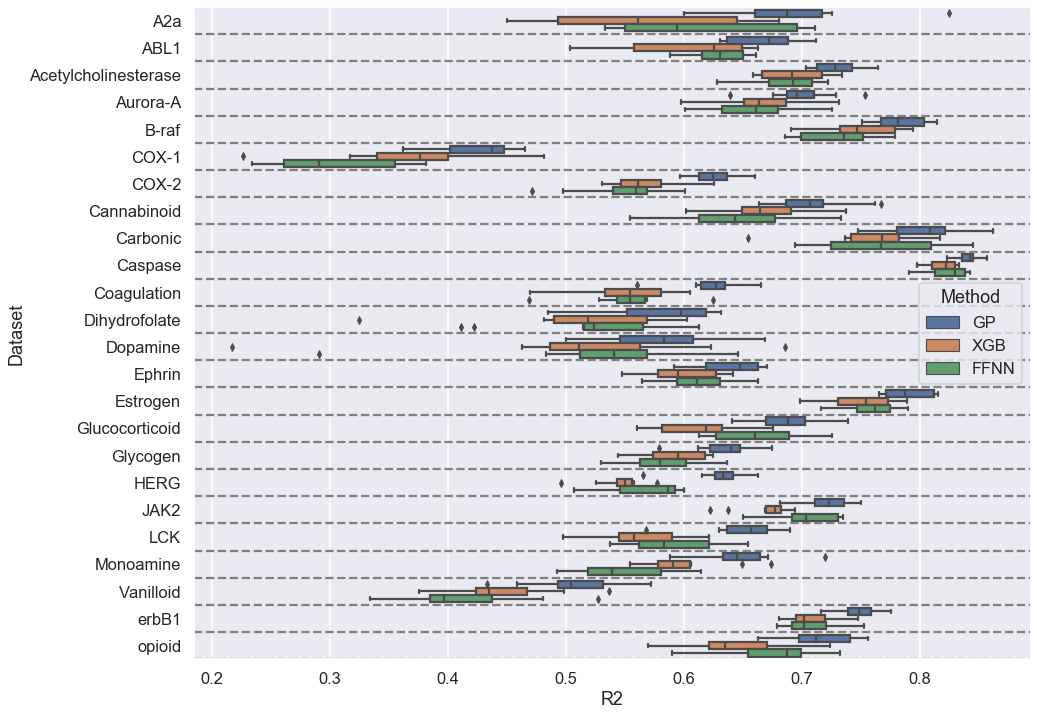

In [49]:
sns.set(rc={'figure.figsize': (15, 12)})
sns.set_context('talk')
ax = sns.boxplot("R2","Dataset",data=r2_df,orient="h",hue="Method")
for i in range(0,24):
    ax.axhline(0.5+i,linestyle="--",color="grey")

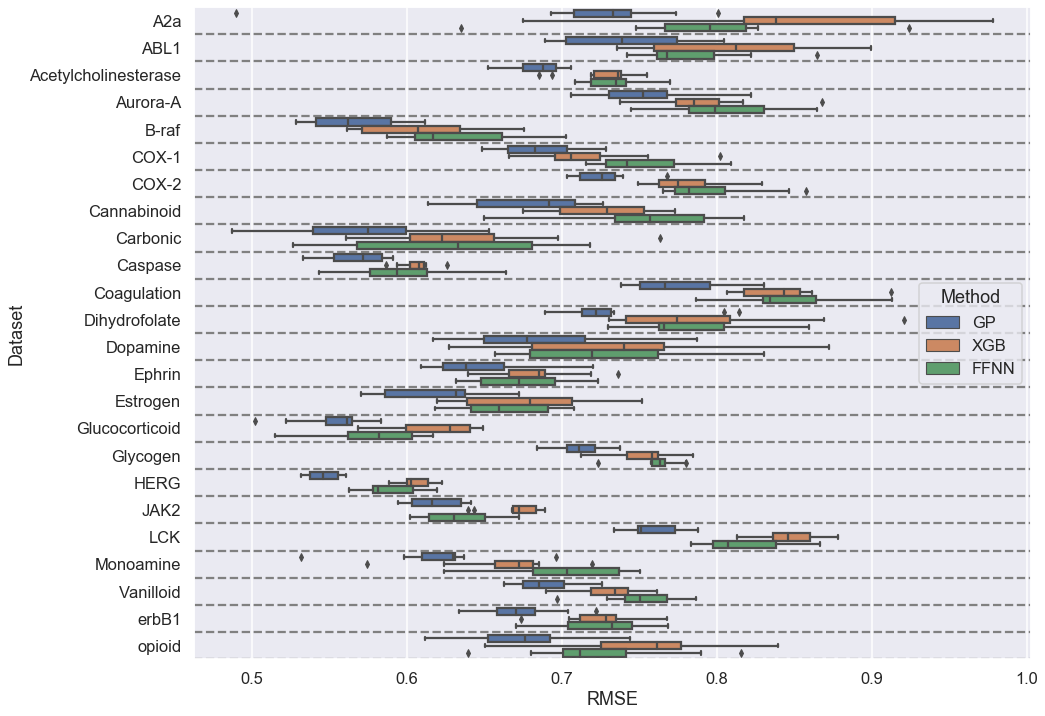

In [55]:
sns.set(rc={'figure.figsize': (15, 12)})
sns.set_context('talk')
ax = sns.boxplot("RMSE","Dataset",data=rms_df,orient="h",hue="Method")
for i in range(0,24):
    ax.axhline(0.5+i,linestyle="--",color="grey")